### Support Vector Machine from Scratch 

#### SVM Classifier

In [1]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from sklearn.metrics import accuracy_score

class SVM:
    
    def __init__(self, C=1.0, gamma=1.0, degree=3.0, kernel='linear'):
        """
        Initializes an instance of an SVM classifier with customizable parameters.
    
        Parameters:
        C (float): Regularization parameter. A higher value leads to a stricter margin with fewer violations.
        gamma (float): Parameter for the RBF kernel. Determines how far the influence of a single training example reaches.
        degree (float): Degree of the polynomial kernel (used only when kernel='poly').
        kernel (str): Specifies the type of kernel function to use ('linear', 'poly', or 'rbf').
    
        Attributes:
        kernel (str): Stores the selected kernel type.
        C (float): Stores the regularization parameter.
        degree (float): Stores the degree for the polynomial kernel.
        gamma (float): Stores the gamma value for the RBF kernel.
        lambdas (ndarray or None): Lagrange multipliers for support vectors (computed during training).
        sv_x (ndarray or None): Support vectors from the training data.
        sv_y (ndarray or None): Labels corresponding to the support vectors.
        sv_lambdas (ndarray or None): Lagrange multipliers associated with support vectors.
        b (float or None): Bias term in the decision function.
        w (ndarray or None): Weight vector (only applicable for a linear kernel).
        """
        self.kernel = kernel
        self.C = C
        self.degree = degree
        self.lambdas = None  # Will store Lagrange multipliers after training
        self.sv_x = None  # Will store support vectors
        self.sv_y = None  # Will store labels corresponding to support vectors
        self.sv_lambdas = None  # Will store Lagrange multipliers of support vectors
        self.b = None  # Bias term for the decision function
        self.w = None  # Weight vector (applicable for linear kernel)
        self.gamma = gamma  # RBF kernel parameter
    
    def poly_kernel(self, a, b):
        """
        Computes the polynomial kernel function.
    
        Parameters:
        a (ndarray): First input vector.
        b (ndarray): Second input vector.
    
        Returns:
        float: The polynomial kernel value computed as (1 + a·b) ^ degree.
        """
        return (1 + np.dot(a, b)) ** self.degree
    
    def rbf_kernel(self, a, b):
        """
        Computes the Radial Basis Function (RBF) kernel.
    
        Parameters:
        a (ndarray): First input vector.
        b (ndarray): Second input vector.
    
        Returns:
        float: The RBF kernel value computed as exp(-gamma * ||a - b||^2).
        """
        return np.exp(-self.gamma * np.linalg.norm(a - b) ** 2)
    
    def fit(self, x, y):
        """
        Trains the Support Vector Machine (SVM) using Quadratic Programming optimization.
    
        Parameters:
        x (ndarray): Training data features (n_samples, n_features).
        y (ndarray): Training data labels (n_samples,). Assumes binary classification with labels {0, 1}.
    
        This function solves the dual optimization problem:
        
            maximize   W(λ) = Σ λ_i - 0.5 * Σ Σ λ_i λ_j y_i y_j K(x_i, x_j)
            subject to  0 ≤ λ_i ≤ C  and  Σ λ_i y_i = 0
            
        where K(x_i, x_j) is the chosen kernel function.
    
        After solving for λ (Lagrange multipliers), it identifies support vectors
        and computes the weight vector (if linear kernel) and bias term (b).
        """
    
        # Convert labels from {0,1} to {-1,1} to match SVM formulation
        y = 2 * y - 1
        n = x.shape[0]  # Number of training samples
    
        # Construct the quadratic programming problem matrix P based on the selected kernel
        if self.kernel == 'linear':
            # Compute Gram matrix for the linear kernel: K(x_i, x_j) = x_i · x_j
            P = matrix(np.outer(y, y) * np.dot(x, x.T))
        elif self.kernel == 'poly':
            # Compute Gram matrix for the polynomial kernel: K(x_i, x_j) = (1 + x_i · x_j) ^ degree
            K = np.array([self.poly_kernel(x[i], x[j]) for i in range(n) for j in range(n)]).reshape(n, n)
            P = matrix(np.outer(y, y) * K, tc='d')
        elif self.kernel == 'rbf':
            # Compute Gram matrix for the RBF kernel: K(x_i, x_j) = exp(-γ ||x_i - x_j||^2)
            K = np.array([self.rbf_kernel(x[i], x[j]) for i in range(n) for j in range(n)]).reshape(n, n)
            P = matrix(np.outer(y, y) * K, tc='d')
        else:
            raise ValueError("Unsupported kernel type")  # Raise an error for unsupported kernel types 
    
        # Define the other quadratic programming matrices
        q = matrix(-np.ones((n, 1)))  # Linear term in the objective function
        A = matrix(y.astype(float), (1, n))  # Equality constraint: Σ λ_i y_i = 0
        b = matrix(0.0)  # Right-hand side of the equality constraint
    
        # Define inequality constraints for Lagrange multipliers λ
        if self.C == 0:  
            # Hard margin SVM (no slack variables): 0 ≤ λ_i
            G = matrix(-np.eye(n))
            h = matrix(np.zeros(n))
        else:  
            # Soft margin SVM: 0 ≤ λ_i ≤ C
            G = matrix(np.vstack([-np.eye(n), np.eye(n)]))
            h = matrix(np.hstack([np.zeros(n), np.ones(n) * self.C]))
    
        # Set solver options for increased numerical precision
        solvers.options['show_progress'] = False  
        solvers.options['abstol'] = 1e-10  
        solvers.options['reltol'] = 1e-10  
        solvers.options['feastol'] = 1e-10  
    
        # Solve the quadratic programming problem
        sol = solvers.qp(P, q, G, h, A, b)  
        self.lambdas = np.ravel(sol['x'])  # Extract solution (Lagrange multipliers)
    
        # Compute weight vector for linear kernel (not needed for non-linear kernels)
        if self.kernel == 'linear':
            self.w = np.dot(self.lambdas * y, x)
        else:
            pass  # No explicit weight vector for non-linear kernels
    
        # Identify support vectors (non-zero Lagrange multipliers)
        self.sv_indices = np.where(self.lambdas > 1e-5)[0]  
        self.sv_lambdas = self.lambdas[self.sv_indices]  
        self.sv_x = x[self.sv_indices]  # Store support vector feature values
        self.sv_y = y[self.sv_indices]  # Store support vector labels
    
        # Compute bias term b
        if self.kernel == 'linear':
            # Separate positive and negative support vectors
            self.sv_pos = self.sv_x[np.where(self.sv_y == 1)[0]]
            self.sv_neg = self.sv_x[np.where(self.sv_y == -1)[0]]
    
            if self.C == 0:  
                # Hard margin SVM: compute b using the mean of all support vectors
                self.b = np.mean(self.sv_y - np.dot(self.sv_x, self.w))
            else:
                # Soft margin SVM: compute b using margin boundary equations
                self.b = -(np.max(np.dot(self.w, self.sv_pos.T)) + np.min(np.dot(self.w, self.sv_neg.T))) / 2.0
        elif self.kernel == 'poly':
            # Compute b using polynomial kernel
            b_values = [
                self.sv_y[i] - sum(
                    self.sv_lambdas[j] * self.sv_y[j] * self.poly_kernel(self.sv_x[i], self.sv_x[j])
                    for j in range(len(self.sv_y))
                )
                for i in range(len(self.sv_y))
            ]
            self.b = np.mean(b_values)  # Take the mean of computed values
        else:
            # Compute b using RBF kernel
            b_values = [
                self.sv_y[i] - sum(
                    self.sv_lambdas[j] * self.sv_y[j] * self.rbf_kernel(self.sv_x[i], self.sv_x[j])
                    for j in range(len(self.sv_y))
                )
                for i in range(len(self.sv_y))
            ]
            self.b = np.mean(b_values)  # Take the mean of computed values
    
    def __decision_boundary(self, x):
        """
        Computes the decision boundary function values for given input samples.
    
        Parameters:
        x (ndarray): Input data points for which the decision boundary function is evaluated.
    
        Returns:
        ndarray: Decision boundary values for input points.
        
        This function calculates:
        
            f(x) = Σ (λ_i * y_i * K(sv_x_i, x)) + b
    
        where:
            - sv_x_i: Support vectors
            - λ_i: Lagrange multipliers of support vectors
            - y_i: Labels of support vectors
            - K(sv_x_i, x): Kernel function applied to support vectors and input x
            - b: Bias term
        """
    
        if self.kernel == 'poly':
            # Compute kernel matrix for polynomial kernel: K(sv_x, x) = (1 + sv_x · x) ^ degree
            x_transform = np.array([
                self.poly_kernel(self.sv_x[i], x[j]) 
                for i in range(len(self.sv_x)) 
                for j in range(len(x))
            ]).reshape(len(self.sv_x), len(x))
    
            # Compute decision boundary function: Σ (λ_i * y_i * K(sv_x_i, x)) + b
            return np.dot(self.sv_lambdas * self.sv_y, x_transform) + self.b
    
        elif self.kernel == 'rbf':
            # Compute kernel matrix for RBF kernel: K(sv_x, x) = exp(-γ ||sv_x - x||^2)
            x_transform = np.array([
                self.rbf_kernel(self.sv_x[i], x[j]) 
                for i in range(len(self.sv_x)) 
                for j in range(len(x))
            ]).reshape(len(self.sv_x), len(x))
    
            # Compute decision boundary function: Σ (λ_i * y_i * K(sv_x_i, x)) + b
            return np.dot(self.sv_lambdas * self.sv_y, x_transform) + self.b

        else:
            # Linear case: f(x) = w · x + b
            # Here, 'w' is the weight vector, and 'b' is the bias term.
            # This is the standard linear decision boundary without a kernel function.
            return np.dot(self.w , x.T) + self.b 
    
    def __kernel_names(self):
        """
        Returns a string representing the name of the selected kernel.
    
        Returns:
        str: Kernel type as a human-readable string.
        """
        if self.kernel == 'linear':
            return 'Linear Kernel'
        elif self.kernel == 'poly':
            return 'Polynomial Kernel'
        else:
            return 'RBF Kernel'
    
    def predict(self, x):
        """
        Predicts the class labels for input samples.
    
        Parameters:
        x (ndarray): Input data points for prediction.
    
        For linear and non-linear kernels, the decision function is computed using the chosen kernel,
        and the sign of the decision_boundary function determines the class label.
        """

        # Use the decision function to classify for linear, polynomial and RBF kernels
        return np.sign(self.__decision_boundary(x))
    
    def compute_margin(self):
        """
        Computes the margin width for the trained SVM model.
    
        Returns:
        float: Margin width, which represents the distance between the decision boundary and support vectors.
        
        The margin is computed using the formula:
            Margin = 2 / ||w||
    
        - For a linear kernel, ||w|| is directly computed from the weight vector.
        - For polynomial and RBF kernels, ||w||^2 is computed from support vectors and Lagrange multipliers.
        """
        if self.kernel == 'linear':
            # Compute margin for a linear kernel: 2 / ||w||
            return 2 / np.sqrt(np.sum(self.w**2))
        elif self.kernel == 'poly':
            # Compute Gram matrix for polynomial kernel: K(sv_x, sv_x)
            K_sv = np.array([
                self.poly_kernel(self.sv_x[i], self.sv_x[j]) 
                for i in range(len(self.sv_y)) 
                for j in range(len(self.sv_y))
            ]).reshape(len(self.sv_y), len(self.sv_y))
    
            # Compute ||w||^2 using support vectors and Lagrange multipliers
            w_norm_squared = np.dot(
                np.dot(self.sv_lambdas, np.outer(self.sv_y, self.sv_y) * K_sv), 
                self.sv_lambdas.reshape(-1, 1)
            )[0]
    
            # Compute margin as 2 / ||w||
            return 2 / np.sqrt(w_norm_squared)
        elif self.kernel == 'rbf':
            # Compute Gram matrix for RBF kernel: K(sv_x, sv_x)
            K_sv = np.array([
                self.rbf_kernel(self.sv_x[i], self.sv_x[j]) 
                for i in range(len(self.sv_y)) 
                for j in range(len(self.sv_y))
            ]).reshape(len(self.sv_y), len(self.sv_y))
    
            # Compute ||w||^2 using support vectors and Lagrange multipliers
            w_norm_squared = np.dot(
                np.dot(self.sv_lambdas, np.outer(self.sv_y, self.sv_y) * K_sv), 
                self.sv_lambdas.reshape(-1, 1)
            )[0]
    
            # Compute margin as 2 / ||w||
            return 2 / np.sqrt(w_norm_squared)
    def coef_(self):
        """
        Returns the coefficient vector (weights) for the decision boundary.
    
        Returns:
        ndarray: Weight vector 'w' for a linear kernel.
    
        If the kernel is non-linear (polynomial or RBF), the weight vector
        cannot be explicitly computed, so a message is printed instead.
        """
        if self.kernel == 'linear':
            return self.w  # Return the learned weight vector for a linear SVM
        else:
            return print("Oops! The coefficients can't be estimated in", self.kernel, 'kernel.')
    
    def intercept_(self):
        """
        Returns the intercept (bias term) of the decision boundary.
    
        Returns:
        float: Bias term 'b' for the model.
        """
        return self.b  # Return the computed bias term
    
    def plot_decision_boundary(self, x, y):
        """
        Plots the decision boundary and margins for a trained SVM model.
    
        Parameters:
        x (ndarray): Input feature matrix (only supports 2D data for visualization).
        y (ndarray): Target labels.
    
        If the kernel is linear, the decision boundary is a straight line,
        and the margin boundaries are plotted as dashed lines. Support vectors
        are also highlighted.
    
        For non-linear kernels (polynomial or RBF), the decision boundary is plotted
        as a contour plot.
        """
        
        plt.figure(figsize=(8, 7))
    
        # Ensure the dataset has two features (2D visualization only)
        if x.shape[1] == 2:
            if self.kernel == 'linear':
                # Retrieve the weight vector and bias term
                w = self.w
                b = self.b
                
                # Assign colors based on class labels
                color = ['red' if a == 1 else 'blue' for a in y]
    
                # Plot the data points
                plt.scatter(x[:, 0], x[:, 1], c=color, alpha=0.7)
                plt.xlim(min(x[:, 0]) - 1, max(x[:, 0]) + 1)
                plt.ylim(min(x[:, 1]) - 1, max(x[:, 1]) + 1)
    
                # Generate x-coordinates for the decision boundary
                x1_dec = np.linspace(min(x[:, 0]) - 2, max(x[:, 0]) + 2, 500).reshape(-1, 1)
    
                # Compute the corresponding y-coordinates using the decision boundary equation: x2 = -(w1/w2) * x1 - b/w2
                x2_dec = -(w[0] / w[1]) * x1_dec - b / w[1]
    
                # Plot the decision boundary
                plt.plot(x1_dec, x2_dec, c='black', lw=2.0, label='Decision Boundary')
    
                # Compute margin boundaries
                w_norm = np.sqrt(np.sum(w**2))  # Compute ||w||
                w_unit = w / w_norm  # Normalize w
                half_margin = 1 / w_norm  # Compute half of the margin width
    
                # Compute positive and negative margin boundaries
                upper = np.hstack([x1_dec, x2_dec]) + half_margin * w_unit
                lower = np.hstack([x1_dec, x2_dec]) - half_margin * w_unit
    
                # Plot margin boundaries
                plt.plot(upper[:, 0], upper[:, 1], '--', lw=2.0, label='Positive Boundary')
                plt.plot(lower[:, 0], lower[:, 1], '--', lw=2.0, label='Negative Boundary')
    
                # Highlight support vectors
                plt.scatter(self.sv_pos[:, 0], self.sv_pos[:, 1], s=50, marker='o', edgecolors='black', c='red', label='+1 Support Vectors')
                plt.scatter(self.sv_neg[:, 0], self.sv_neg[:, 1], s=50, marker='o', edgecolors='black', c='blue', label='-1 Support Vectors')
    
                # Configure the legend and title
                plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10, frameon=True, fancybox=True, shadow=True)
                plt.title(f"SVM Decision Boundary and Margins with {self.__kernel_names()}")
                plt.show()
    
            else:
                # Create a mesh grid for contour plotting
                xx, yy = np.meshgrid(
                    np.linspace(min(x[:, 0]) - 0.5, max(x[:, 0]) + 0.5, 500),
                    np.linspace(min(x[:, 1]) - 0.5, max(x[:, 1]) + 0.5, 500)
                )
    
                # Flatten grid to compute decision boundary values
                grid = np.c_[xx.ravel(), yy.ravel()]
                Z = self.__decision_boundary(grid).reshape(xx.shape)
    
                # Plot decision boundary contours
                plt.contour(xx, yy, Z, levels=[-1, 0, 1], colors=['blue', 'black', 'red'], linestyles=['dashed', 'solid', 'dashed'], linewidths=2)
    
                # Legend handles
                handles = [
                    plt.Line2D([0], [0], color='blue', linestyle='dashed', linewidth=2, label='Negative Margin (-1)'),
                    plt.Line2D([0], [0], color='black', linestyle='solid', linewidth=2, label='Decision Boundary (0)'),
                    plt.Line2D([0], [0], color='red', linestyle='dashed', linewidth=2, label='Positive Margin (+1)')
                ]
    
                # Plot data points and highlight support vectors
                plt.scatter(x[:, 0], x[:, 1], c=y, cmap='bwr', alpha=0.7)
                plt.scatter(self.sv_x[:, 0], self.sv_x[:, 1], s=50, edgecolors='k', facecolors='none', label="Support Vectors")
    
                # Configure title, labels, and legend
                plt.title(f"SVM Decision Boundary and Margins with {self.__kernel_names()}")
                plt.legend(handles=handles, loc="center left", bbox_to_anchor=(1, 0.5), fontsize=10, frameon=True, fancybox=True, shadow=True)
                plt.xlabel("x1")
                plt.ylabel("x2")
                plt.show()
        else:
            return "Oops! The given data can't be visualized in a 2D plane."
    
    def compare_with_sklearn(self, x, y):
        """
        Compares the custom SVM implementation with Scikit-Learn's SVC.
        
        Parameters:
        x (ndarray): Input feature matrix.
        y (ndarray): Target labels.
        
        The function trains a Scikit-Learn SVM model using the same kernel and hyperparameters,
        prints the computed coefficients, intercepts, and the number of support vectors.
        """
        # Initialize the Scikit-Learn SVM model with the corresponding kernel and hyperparameters
        if self.kernel == 'linear' and self.C == 0:
            sklearn_svm = SVC(kernel='linear')  # Hard-margin SVM (no regularization)
        elif self.kernel == 'linear' and self.C != 0:
            sklearn_svm = SVC(C=self.C, kernel='linear')  # Soft-margin SVM with regularization
        elif self.kernel == 'poly':
            sklearn_svm = SVC(kernel="poly", degree=self.degree, C=self.C, coef0=1, gamma=1.0)  # Polynomial kernel
        else:
            sklearn_svm = SVC(kernel=self.kernel, C=self.C, gamma=self.gamma)  # RBF kernels
        
        # Train the Scikit-Learn SVM model
        sklearn_svm.fit(x, y)
        
        # Print coefficient comparison for linear kernel
        if self.kernel == 'linear':
            print(f"Computed Coefficients (w) - CVXOPT: {self.w}")
            print(f"Coefficients (w) - Scikit-Learn: {sklearn_svm.coef_[0]}")
            
        # Print intercept and number of support vectors
        print(f"Computed Intercept (b) - CVXOPT: {self.b:.4f}")
        print(f"Intercept (b) - Scikit-Learn: {sklearn_svm.intercept_[0]:.4f}")
        print(f"Number of Support Vectors - CVXOPT: {len(self.sv_x)}")
        print(f"Number of Support Vectors - Scikit-Learn: {len(sklearn_svm.support_)}")

        # Predict labels using both the custom and sklearn models
        y_pred_custom = np.where(self.predict(x) == -1 , 0 , 1)
        y_pred_sklearn = sklearn_svm.predict(x)
        
        # Compute accuracy scores for both models
        acc_custom = accuracy_score(y, y_pred_custom)
        acc_sklearn = accuracy_score(y, y_pred_sklearn)
        
        # Print the accuracy comparison
        print("\nCustom SVM Accuracy:", acc_custom)
        print("Sklearn SVM Accuracy:", acc_sklearn)
    
    def support_vectors(self):
        """
        Returns a DataFrame containing support vectors and corresponding values.
        
        For a linear kernel and non-linear kernels, the DataFrame includes:
            - Feature values of support vectors
            - Lagrange multipliers (λ)
            - Decision_value, representing margin violations
        
        Returns:
            pd.DataFrame: DataFrame containing support vector details.
        """

        d = self.sv_x.shape[1] # Number of features

        # Compute the model's predictions for support vectors
        y_hat = self.__decision_boundary(self.sv_x)

        # Create a DataFrame with feature values
        df = pd.DataFrame(self.sv_x, columns=[f'Feature_{i+1}' for i in range(d)])

        # Add Lagrange multipliers (rounded to 4 decimal places)
        df['λ'] = list(round(i,4) for i in self.lambdas[self.sv_indices])

        # Compute Decision Value: measures how much a point violates the margin (rounded to 5 decimal places)
        df['Decision_Value'] = [round(i,4) for i in 1 - np.maximum(0 , 1 - self.sv_y * y_hat) - (self.sv_y * y_hat)]
            
        return df

#### SVM Multiclass Classification (One vs One)

In [2]:
import numpy as np
from itertools import combinations
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

class OvoSVM:

    def __init__(self, C=1.0, kernel='linear', degree=3, gamma=1.0):
        """
        Initializes the parameters for a Support Vector Machine (SVM) classifier.
    
        Parameters:
        - C (float, default=1.0): Regularization parameter that controls the trade-off 
          between maximizing the margin and minimizing classification errors. 
          A smaller C encourages a larger margin with more misclassifications, while a 
          larger C results in a smaller margin with fewer misclassifications.
          
        - kernel (str, default='linear'): Specifies the kernel type to be used in the 
          SVM model. Common choices include:
            - 'linear': Linear kernel
            - 'poly': Polynomial kernel
            - 'rbf': Radial Basis Function (Gaussian) kernel
            - 'sigmoid': Sigmoid kernel
          
        - degree (int, default=3): Relevant only for the polynomial kernel. Specifies 
          the degree of the polynomial function used to transform the input data.
    
        - gamma (float, default=1.0): Kernel coefficient for 'rbf', 'poly', and 'sigmoid' 
          kernels. Determines how much influence a single training example has. A higher 
          gamma leads to more influence (tight fit to training data), while a lower gamma 
          results in a looser fit.
    
        Attributes:
        - comb (list): Stores the all combination of 2 features in the data.
        - w (list): Stores the weight vector for linear classification (only used for 
          linear kernels).
        - b (list): Bias term associated with the decision boundary.
        - sv_x (list): Stores the support vectors (training samples that define the 
          decision boundary).
        - sv_y (list): Labels corresponding to the support vectors.
        - sv_lambdas (list): Lagrange multipliers (dual problem solutions) for the 
          support vectors in the optimization process.
    
        """
        self.C = C
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.comb = []  # Placeholder for potential combinations used in training
        self.w = []  # Weight vector (used in linear classification)
        self.b = []  # Bias term for the decision function
        self.sv_x = []  # Support vectors from training data
        self.sv_y = []  # Corresponding labels of support vectors
        self.sv_lambdas = []  # Lagrange multipliers for support vectors

    def poly_kernel(self, a, b):
        """
        Computes the polynomial kernel between two vectors.
    
        Parameters:
        - a (numpy array): First input vector.
        - b (numpy array): Second input vector.
    
        Returns:
        - float: Computed polynomial kernel value.
        
        Formula:
            K(a, b) = (1 + a ⋅ b^T) ^ degree
        """
        return (1 + np.dot(a, b.T)) ** self.degree


    def rbf_kernel(self, a, b):
        """
        Computes the Radial Basis Function (RBF) kernel between two vectors.
    
        Parameters:
        - a (numpy array): First input vector.
        - b (numpy array): Second input vector.
    
        Returns:
        - float: Computed RBF kernel value.
    
        Formula:
            K(a, b) = exp(-γ ||a - b||²)
        
        where:
        - γ (self.gamma) is a hyperparameter controlling the influence of training samples.
        - ||a - b||² is the squared Euclidean distance between vectors.
        """
        return np.exp(-self.gamma * np.linalg.norm(a - b) ** 2)
    

    def fit(self, x, y):
        """
        Trains a multi-class SVM using a one-vs-one (OvO) strategy.
    
        Parameters:
        - x (numpy array): Feature matrix of shape (n_samples, n_features).
        - y (numpy array): Target labels of shape (n_samples,).
    
        The method follows these steps:
        1. Identifies all unique class pairs for a one-vs-one (OvO) classification.
        2. Iterates through each class pair and trains an individual binary SVM.
        3. Stores the trained parameters for later use in prediction.
    
        """
        # Generate all unique class pairs for the one-vs-one strategy
        self.comb = list(combinations(np.unique(y), 2))
    
        for i, j in self.comb:
            # Find indices of samples belonging to the current class pair
            index = np.where(np.isin(y, [i, j]))[0]
    
            # Convert the class labels to binary (1 for class 'i', 0 for class 'j')
            y_binary = np.where(y[index] == i, 1, 0)
    
            # Instantiate an SVM with the appropriate kernel type
            if self.kernel == 'poly':
                svm = SVM(C=self.C, kernel=self.kernel, degree=self.degree)
            elif self.kernel == 'rbf':
                svm = SVM(C=self.C, kernel=self.kernel, gamma=self.gamma)
            else:  # Default to a linear SVM
                svm = SVM(C=self.C)
    
            # Train the binary SVM on the selected subset of data
            svm.fit(x[index], y_binary)
    
            # Store the intercept (bias term)
            self.b.append(svm.intercept_())
    
            # Store additional model parameters depending on the kernel type
            if self.kernel in ['poly', 'rbf']:
                self.sv_x.append(svm.sv_x)  # Support vectors
                self.sv_y.append(svm.sv_y)  # Support vector labels
                self.sv_lambdas.append(svm.sv_lambdas)  # Lagrange multipliers
            else:
                self.w.append(svm.coef_().flatten())  # Store weight vector for linear SVM
    
        # Convert lists to NumPy arrays for efficient computation
        if self.w:
            self.w = np.array(self.w)
        self.b = np.array(self.b)

    def coef_(self):
        """
        Retrieves the weight vector (w) of the trained SVM model.
    
        Returns:
        - numpy array: Weight vector used for classification (only for linear kernel).
    
        Raises:
        - AttributeError: If the kernel is not linear, as weight vectors are not applicable 
          for non-linear kernels like polynomial or RBF.
    
        Explanation:
        - For linear SVMs, the decision boundary is defined as:
            f(x) = w ⋅ x + b
          where 'w' is the weight vector and 'b' is the bias (intercept).
        - Non-linear kernels (e.g., polynomial, RBF) do not explicitly compute a weight 
          vector, as they rely on support vectors and kernel functions for classification.
        """
        if self.kernel == 'linear':
            return self.w
        else:
            raise AttributeError("Coefficient (w) is only available for linear kernels.")
    
    
    def intercept_(self):
        """
        Retrieves the bias term (intercept) of the trained SVM model.
    
        Returns:
        - numpy array: The bias term (b), which is used in the decision function.
    
        Explanation:
        - The intercept is a scalar value that adjusts the decision boundary.
        - It is present in both linear and non-linear SVMs.
        - In linear SVM, the decision function is:
            f(x) = w ⋅ x + b
        - In non-linear SVMs, the bias term still contributes to the classification but 
          is used alongside the kernel function and support vectors.
        """
        return self.b

    def predict(self, x):
        """
        Predicts the class labels for the given input samples.
    
        Parameters:
        - x (numpy array): Input feature matrix of shape (n_samples, n_features).
    
        Returns:
        - numpy array: Predicted class labels for each input sample.
    
        Explanation:
        - Uses a one-vs-one (OvO) classification strategy to classify input samples.
        - Computes the decision function for each binary classifier and collects votes.
        - The final class label is determined by majority voting.
    
        """
        df = []  # List to store predictions from each binary classifier
    
        # Iterate over each binary classifier trained on a class pair
        for k in range(len(self.comb)):
            if self.kernel == 'poly':
                # Compute the polynomial kernel transformation
                x_transform = np.array([
                    self.poly_kernel(self.sv_x[k][i], x[j])
                    for i in range(len(self.sv_x[k])) for j in range(len(x))
                ]).reshape(len(self.sv_x[k]), len(x))
    
            elif self.kernel == 'rbf':
                # Compute the RBF kernel transformation
                x_transform = np.array([
                    self.rbf_kernel(self.sv_x[k][i], x[j])
                    for i in range(len(self.sv_x[k])) for j in range(len(x))
                ]).reshape(len(self.sv_x[k]), len(x))
    
            else:
                # Linear SVM case: compute dot product with weight vector
                x_transform = np.dot(self.w[k], x.T)
    
            # Compute the decision function
            if self.kernel in ['poly', 'rbf']:
                pred = np.sign(np.dot(self.sv_lambdas[k] * self.sv_y[k], x_transform) + self.b[k])
            else:
                pred = np.sign(x_transform + self.b[k])
    
            # Store the binary classification results
            df.append(pred.tolist())
    
        # Convert predictions list to a NumPy array and transpose
        df = np.array(df).T  # Shape: (n_samples, n_classifiers)
    
        predictions = []  # List to store final predicted labels
    
        # Iterate over each sample to determine the final class label
        for i in range(df.shape[0]):
            votes = np.zeros(len(np.unique(y)))  # Array to store votes for each class
    
            # Iterate through predictions from all classifiers
            for j in range(df.shape[1]):
                if df[i, j] == 1:
                    votes[self.comb[j][0]] += 1  # Vote for class 1
                else:
                    votes[self.comb[j][1]] += 1  # Vote for class 2
    
            # Assign the class with the highest vote count
            predictions.append(np.argmax(votes))
    
        return np.array(predictions)

    def compare_with_sklearn(self, x, y):
        """
        Compares the custom SVM implementation with Scikit-Learn's SVM.
    
        Parameters:
        - x (numpy array): Feature matrix of shape (n_samples, n_features).
        - y (numpy array): Target labels of shape (n_samples,).
    
        The function follows these steps:
        1. Creates a Scikit-Learn SVM model with the same kernel and hyperparameters.
        2. Trains the Scikit-Learn SVM on the given dataset.
        3. Compares the intercept (bias term) of the custom and Scikit-Learn SVMs.
        4. If using a linear kernel, also compares the weight vectors (coefficients).
    
        """
        # Initialize Scikit-Learn's SVM with the same kernel and hyperparameters
        if self.kernel == 'linear':
            if self.C == 0:  # Handle edge case where C is zero (no regularization)
                svm_sklearn = SVC(kernel='linear', decision_function_shape='ovo')
            else:
                svm_sklearn = SVC(kernel='linear', C=self.C, decision_function_shape='ovo')
    
        elif self.kernel == 'poly':
            svm_sklearn = SVC(kernel='poly', degree=self.degree, C=self.C,
                              decision_function_shape='ovo', coef0=1, gamma=1.0)
    
        elif self.kernel == 'rbf':
            svm_sklearn = SVC(kernel='rbf', C=self.C, gamma=self.gamma,
                              decision_function_shape='ovo')
    
        else:
            raise ValueError("Unsupported kernel type")
    
        # Train the Scikit-Learn SVM model
        svm_sklearn.fit(x, y)
    
        # Compare intercept values (bias terms)
        print("Comparison of Intercepts (b):\n")
        print(f"Custom OvO: {self.b}")
        print(f"Scikit-Learn: {svm_sklearn.intercept_}")
    
        # Compare weight vectors if using a linear kernel
        if self.kernel == 'linear':
            print("\nComparison of Coefficients (w):\n")
            for i, (custom_w, sklearn_w) in enumerate(zip(self.w, svm_sklearn.coef_)):
                print(f"Classifier {i+1} (Classes {self.comb[i]}):")
                print(f"Custom OvO Coefficients: {custom_w}")
                print(f"Scikit-Learn Coefficients: {sklearn_w}\n")

        # Predict labels using both the custom and sklearn models
        y_pred_custom = self.predict(x)
        y_pred_sklearn = svm_sklearn.predict(x)
        
        # Compute accuracy scores for both models
        acc_custom = accuracy_score(y, y_pred_custom)
        acc_sklearn = accuracy_score(y, y_pred_sklearn)
        
        # Print the accuracy comparison
        print("\nCustom OvO Accuracy:", acc_custom)
        print("Sklearn OvO Accuracy:", acc_sklearn)

#### SVM Multiclass Classification (One vs Rest)

In [3]:
import numpy as np
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import accuracy_score

class OvrSVM:
    def __init__(self, kernel='poly', C=1, degree=3, gamma=1.0):
        """
        Initializes an instance of the One-vs-Rest SVM classifier.
        
        Parameters:
        kernel (str): Type of kernel function ('poly' for polynomial, 'rbf' for radial basis function).
        C (float): Regularization parameter that controls the trade-off between achieving a low error and maintaining a simple model.
        degree (int): Degree of the polynomial kernel (used if kernel='poly').
        gamma (float): Kernel coefficient for the RBF kernel (used if kernel='rbf').
        """
        self.kernel = kernel  # Store the type of kernel to be used
        self.C = C  # Regularization parameter
        self.degree = degree  # Degree for polynomial kernel
        self.gamma = gamma  # Gamma parameter for RBF kernel
        self.classes_ = None  # To store unique class labels
        self.b = []  # Bias term for each classifier
        self.sv_x = []  # Support vectors (input features)
        self.sv_y = []  # Labels of the support vectors
        self.sv_lambdas = []  # Lagrange multipliers for support vectors
        self.w = None  # Weight vector (only used for linear kernel, if applicable)
    
    def poly_kernel(self, a, b):
        """
        Computes the polynomial kernel function.
        
        Parameters:
        a (ndarray): First input vector or matrix.
        b (ndarray): Second input vector or matrix.
        
        Returns:
        float: The computed polynomial kernel value.
        """
        return (1 + np.dot(a, b.T)) ** self.degree  # Polynomial kernel formula

    def rbf_kernel(self, a, b):
        """
        Computes the Radial Basis Function (RBF) kernel.
        
        Parameters:
        a (ndarray): First input vector.
        b (ndarray): Second input vector.
        
        Returns:
        float: The computed RBF kernel value.
        """
        return np.exp(-self.gamma * np.linalg.norm(a - b) ** 2)  # RBF kernel formula

    def fit(self, x, y):
        """
        Trains the One-vs-Rest SVM model for multi-class classification.
        
        Parameters:
        x (ndarray): Training feature matrix.
        y (ndarray): Training labels.
        """
        self.classes_ = np.unique(y)  # Identify unique class labels
        self.w = []  # Initialize weight storage (for linear kernel)
        self.b = []  # Initialize bias storage

        for class_label in self.classes_:
            y_binary = np.where(y == class_label, 1, 0)  # Convert labels to binary (1 for class, 0 otherwise)
            
            # Initialize appropriate SVM model based on the selected kernel
            if self.kernel == 'linear':
                model = SVM(kernel='linear', C=self.C)
            elif self.kernel == 'poly':
                model = SVM(kernel='poly', C=self.C, degree=self.degree)
            elif self.kernel == 'rbf':
                model = SVM(kernel='rbf', C=self.C, gamma=self.gamma)
            else:
                raise ValueError("Unsupported kernel type")  # Raise an error for unsupported kernel types
            
            model.fit(x, y_binary)  # Train the model on the binary-labeled data
            self.b.append(model.intercept_())  # Store the learned bias term
            
            if self.kernel == 'linear':
                self.w.append(model.coef_().flatten())  # Store weight vector for linear kernel
            else:
                # Store support vector details for non-linear kernels
                self.sv_x.append(model.sv_x)
                self.sv_y.append(model.sv_y)
                self.sv_lambdas.append(model.sv_lambdas)

        # Convert weight list to numpy array if using a linear kernel, else set to None
        self.w = np.array(self.w) if self.kernel == 'linear' else None
        self.b = np.array(self.b)  # Convert bias list to numpy array

    def decision_function(self, x):
        """
        Computes the decision function for each class.
        
        Parameters:
        x (ndarray): Input feature matrix.
        
        Returns:
        ndarray: Decision function values for each class.
        """
        if self.kernel == 'linear':
            return np.dot(self.w, x.T).T + self.b  # Linear kernel decision function
        else:
            df = []  # List to store decision function values for each class
            for k in range(len(self.classes_)):
                if self.kernel == 'poly':
                    # Compute polynomial kernel transformation
                    x_transform = np.array([
                        self.poly_kernel(self.sv_x[k][i], x[j])
                        for i in range(len(self.sv_x[k])) for j in range(len(x))
                    ]).reshape(len(self.sv_x[k]), len(x))
                elif self.kernel == 'rbf':
                    # Compute RBF kernel transformation
                    x_transform = np.array([
                        self.rbf_kernel(self.sv_x[k][i], x[j])
                        for i in range(len(self.sv_x[k])) for j in range(len(x))
                    ]).reshape(len(self.sv_x[k]), len(x))
                else:
                    raise ValueError("Unsupported kernel type")  # Raise an error for unsupported kernel types
                
                pred = np.dot(self.sv_lambdas[k] * self.sv_y[k], x_transform) + self.b[k]  # Compute decision function
                df.append(pred.tolist())  # Append results for each class
            return np.array(df).T  # Return decision function values as a transposed array

    def predict(self, x):
        """
        Predicts class labels for the given input data.
        
        Parameters:
        x (ndarray): Input feature matrix.
        
        Returns:
        ndarray: Predicted class labels.
        """
        df = self.decision_function(x)  # Compute decision function values
        return self.classes_[np.argmax(df, axis=1)]  # Assign the class with the highest score
    
    def compare_with_sklearn(self, x, y):
        """
        Compares the custom One-vs-Rest SVM model with sklearn's OneVsRestClassifier.
        
        Parameters:
        x (ndarray): Input feature matrix.
        y (ndarray): True class labels.
        """
        # Initialize sklearn's OneVsRestClassifier with appropriate SVM model based on the kernel type
        if self.kernel == 'linear':
            if self.C == 0:
                sklearn_model = OneVsRestClassifier(SVC(kernel='linear'))  # Default regularization if C=0
            else:
                sklearn_model = OneVsRestClassifier(SVC(kernel='linear', C=self.C))
        elif self.kernel == 'poly':
            sklearn_model = OneVsRestClassifier(SVC(kernel='poly', C=self.C, degree=self.degree, coef0=1, gamma=1.0))
        elif self.kernel == 'rbf':
            sklearn_model = OneVsRestClassifier(SVC(kernel='rbf', C=self.C, gamma=self.gamma))
        else:
            raise ValueError("Unsupported kernel type")  # Raise an error for unsupported kernel types
        
        sklearn_model.fit(x, y)  # Train the sklearn model
        
        if self.kernel == 'linear':
            # Extract weights from sklearn's trained classifiers
            w_sklearn = np.vstack([clf.coef_.flatten() for clf in sklearn_model.estimators_])
            print("\nCustom OvR Weights:\n", self.w)  # Print custom model weights
            print("Sklearn OvR Weights:\n", w_sklearn)  # Print sklearn model weights
        
        # Extract bias terms from sklearn's trained classifiers
        b_sklearn = np.array([clf.intercept_[0] for clf in sklearn_model.estimators_])
        print("\nCustom OvR Biases:\n", self.b)  # Print custom model biases
        print("Sklearn OvR Biases:\n", b_sklearn)  # Print sklearn model biases
        
        # Predict labels using both the custom and sklearn models
        y_pred_custom = self.predict(x)
        y_pred_sklearn = sklearn_model.predict(x)
        
        # Compute accuracy scores for both models
        acc_custom = accuracy_score(y, y_pred_custom)
        acc_sklearn = accuracy_score(y, y_pred_sklearn)
        
        # Print the accuracy comparison
        print("\nCustom OvR Accuracy:", acc_custom)
        print("Sklearn OvR Accuracy:", acc_sklearn)

### Linear Kernel

#### Problem 1

In [4]:
from sklearn.datasets import make_blobs

x, y = make_blobs(n_samples = 1000 , centers=2, n_features = 2 , cluster_std = 4 , random_state=42)

In [5]:
svm = SVM(C=1 , kernel='linear')

In [6]:
svm.fit(x , y)

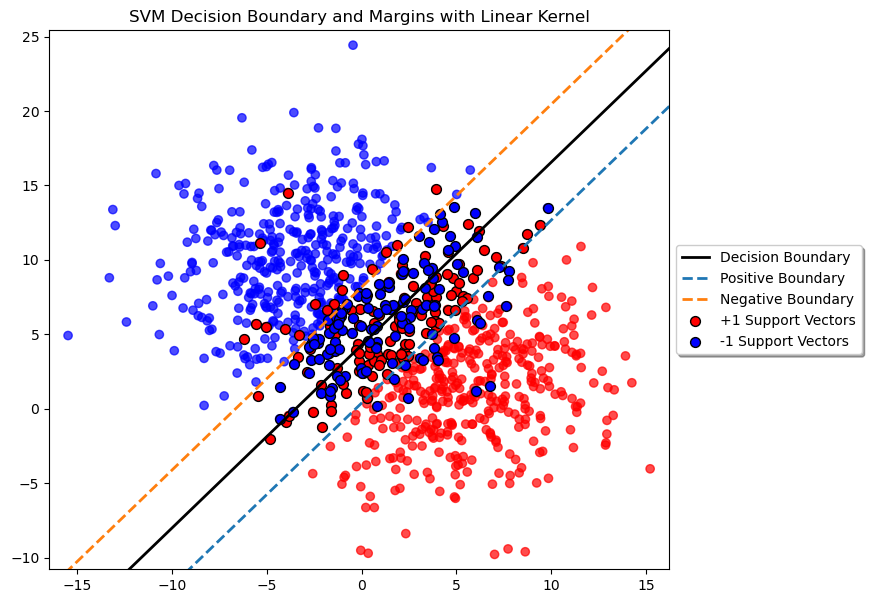

In [7]:
svm.plot_decision_boundary(x,y)

In [8]:
svm.compare_with_sklearn(x,y)

Computed Coefficients (w) - CVXOPT: [ 0.31578621 -0.25695871]
Coefficients (w) - Scikit-Learn: [ 0.31577776 -0.25695497]
Computed Intercept (b) - CVXOPT: 1.0963
Intercept (b) - Scikit-Learn: 1.0963
Number of Support Vectors - CVXOPT: 251
Number of Support Vectors - Scikit-Learn: 251

Custom SVM Accuracy: 0.898
Sklearn SVM Accuracy: 0.898


In [9]:
svm.compute_margin()

4.912526589496866

In [10]:
svm.support_vectors()

,Feature_1,Feature_2,λ,Decision_Value
0,0.833571,4.495459,1.0,0.0
1,3.917959,14.745600,1.0,0.0
2,0.819389,3.667566,1.0,0.0
3,-5.357744,11.136940,1.0,0.0
4,-2.131948,1.579811,1.0,0.0
...,...,...,...,...
246,-0.143653,3.751580,1.0,0.0
247,-2.860811,2.433274,1.0,0.0
248,7.731141,8.630047,1.0,0.0
249,4.552619,10.634213,1.0,0.0


#### Problem 2

In [11]:
from sklearn.datasets import make_blobs

x, y = make_blobs(n_samples = 1000 , centers=2, n_features = 2 , cluster_std = 1.2 , random_state=42)

In [12]:
svm = SVM(C=0 , kernel='linear')

In [13]:
svm.fit(x , y)

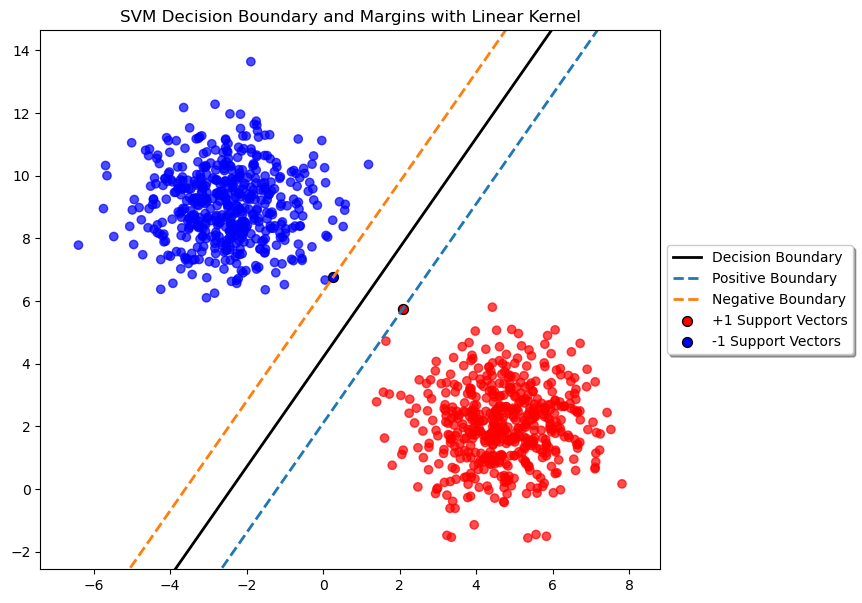

In [14]:
svm.plot_decision_boundary(x,y)

In [15]:
svm.compare_with_sklearn(x,y)

Computed Coefficients (w) - CVXOPT: [ 0.83296494 -0.4767031 ]
Coefficients (w) - Scikit-Learn: [ 0.83296469 -0.47670296]
Computed Intercept (b) - CVXOPT: 2.0054
Intercept (b) - Scikit-Learn: 2.0054
Number of Support Vectors - CVXOPT: 2
Number of Support Vectors - Scikit-Learn: 2

Custom SVM Accuracy: 1.0
Sklearn SVM Accuracy: 1.0


In [16]:
svm.compute_margin()

2.08392535543691

In [17]:
svm.support_vectors()

,Feature_1,Feature_2,λ,Decision_Value
0,2.077070,5.738468,0.4605,-0.0
1,0.268393,6.773568,0.4605,-0.0


## Polynomial Kernel

#### Problem 1

In [18]:
from sklearn.datasets import make_moons
x, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

In [19]:
svm = SVM(C=1 , kernel='poly' , degree = 5)

In [20]:
svm.fit(x,y)

In [21]:
svm.compare_with_sklearn(x,y)

Computed Intercept (b) - CVXOPT: 2.4561
Intercept (b) - Scikit-Learn: 2.5265
Number of Support Vectors - CVXOPT: 16
Number of Support Vectors - Scikit-Learn: 16

Custom SVM Accuracy: 1.0
Sklearn SVM Accuracy: 1.0


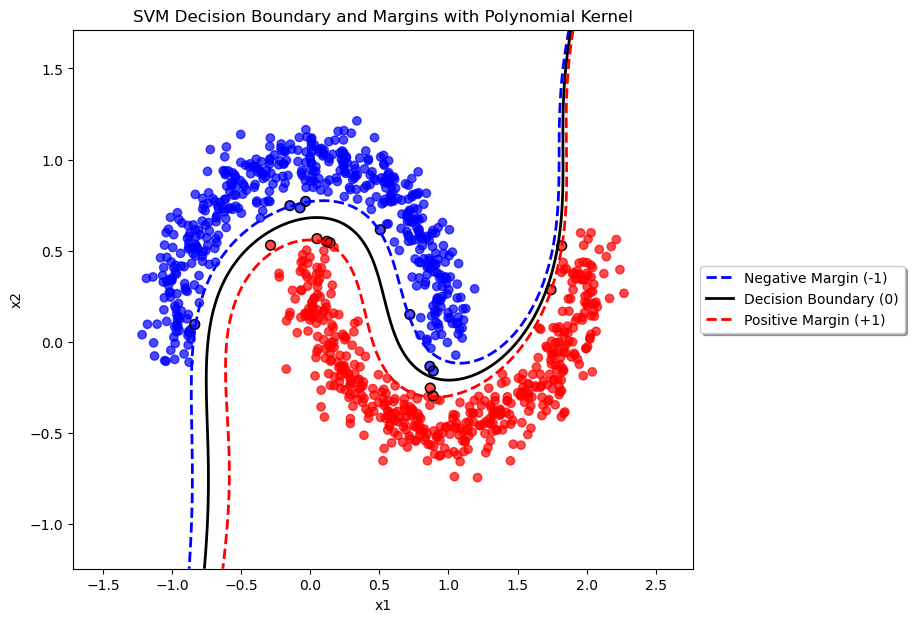

In [22]:
svm.plot_decision_boundary(x,y)

In [23]:
svm.compute_margin()

0.7012101875933302

In [24]:
svm.support_vectors()

,Feature_1,Feature_2,λ,Decision_Value
0,0.867892,-0.254827,1.0000,0.0000
1,-0.035184,0.770153,0.1445,-0.0709
2,1.819831,0.526387,0.0006,0.0000
3,-0.148415,0.746781,1.0000,-0.0572
4,-0.288827,0.529327,1.0000,0.0000
5,0.720247,0.149292,0.6646,-0.0709
6,0.888276,-0.297301,0.7550,0.0000
7,0.506037,0.614392,0.1450,-0.0709
8,0.047276,0.565674,0.9694,0.0000
9,-0.075292,0.734688,1.0000,0.0000


#### Problem 2

In [25]:
from sklearn.datasets import make_circles
x , y = make_circles(n_samples=1000, noise=0.1 , factor=0.5, random_state=42)

In [26]:
svm = SVM(C=1 , kernel='poly' , degree = 3)

In [27]:
svm.fit(x,y)

In [28]:
svm.compare_with_sklearn(x,y)

Computed Intercept (b) - CVXOPT: 4.1488
Intercept (b) - Scikit-Learn: 4.1233
Number of Support Vectors - CVXOPT: 67
Number of Support Vectors - Scikit-Learn: 67

Custom SVM Accuracy: 0.995
Sklearn SVM Accuracy: 0.996


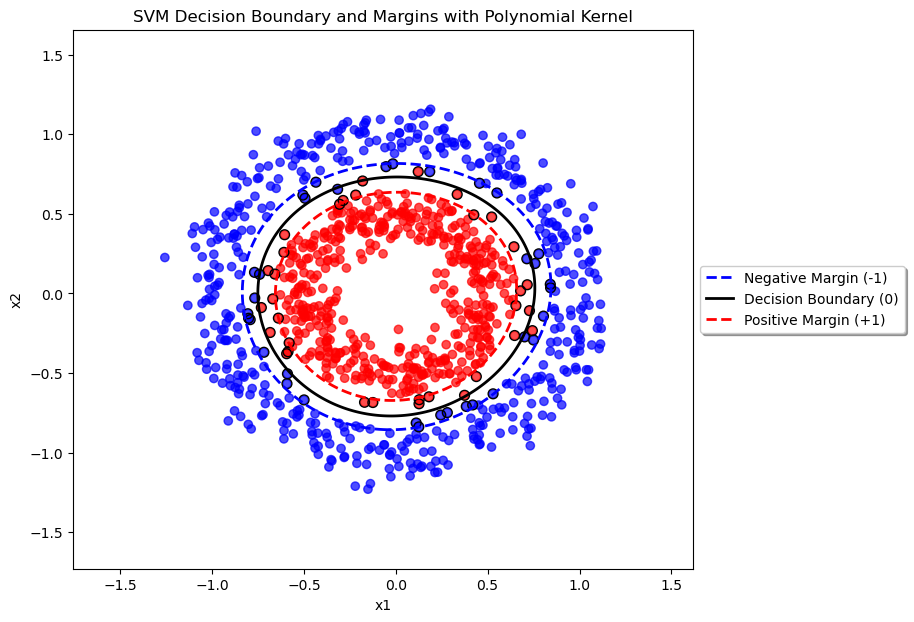

In [29]:
svm.plot_decision_boundary(x,y)

In [30]:
svm.compute_margin()

0.33243199385229083

In [31]:
svm.support_vectors()

,Feature_1,Feature_2,λ,Decision_Value
0,-0.580965,-0.310749,0.4203,-0.0256
1,0.424580,0.494119,0.9983,-0.0256
2,0.727418,-0.108077,1.0000,0.0000
3,0.374011,-0.640243,1.0000,0.0000
4,0.715366,0.054661,1.0000,0.0000
...,...,...,...,...
62,-0.801698,-0.155982,1.0000,0.0000
63,-0.506171,0.618593,1.0000,0.0000
64,-0.218579,0.618532,1.0000,0.0000
65,0.700895,-0.273092,1.0000,0.0000


## RBF Kernel

#### Problem 1

In [32]:
from sklearn.datasets import make_moons

x, y = make_moons(n_samples=1000, noise=0.1, random_state=42)

In [33]:
svm = SVM(C = 1, gamma = 2 , kernel='rbf')

In [34]:
svm.fit(x, y)

In [35]:
svm.compare_with_sklearn(x,y)

Computed Intercept (b) - CVXOPT: 0.0103
Intercept (b) - Scikit-Learn: 0.0142
Number of Support Vectors - CVXOPT: 43
Number of Support Vectors - Scikit-Learn: 43

Custom SVM Accuracy: 1.0
Sklearn SVM Accuracy: 0.999


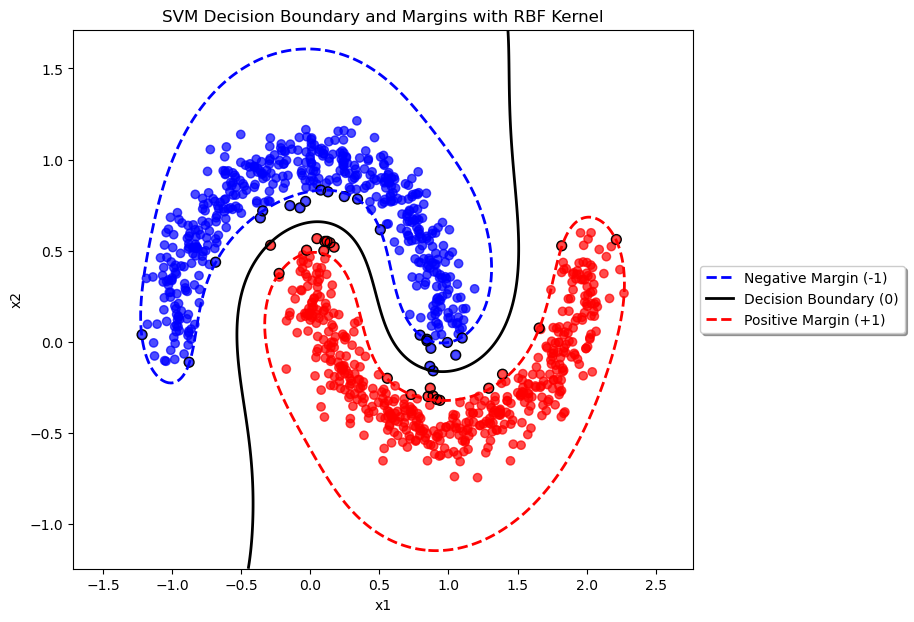

In [36]:
svm.plot_decision_boundary(x,y)

In [37]:
svm.compute_margin()

0.3598589529269749

In [38]:
svm.support_vectors()

,Feature_1,Feature_2,λ,Decision_Value
0,0.867892,-0.254827,1.0000,0.0000
1,-0.035184,0.770153,1.0000,0.0000
2,2.215504,0.560930,0.2870,0.0000
3,0.171630,0.518985,1.0000,0.0000
4,1.819831,0.526387,0.6414,0.0000
5,-0.148415,0.746781,1.0000,0.0000
6,0.794271,0.036006,1.0000,0.0000
7,0.938242,-0.321835,0.8398,0.0000
8,-0.878606,-0.112676,0.9900,-0.0040
9,0.556942,-0.200634,1.0000,0.0000


#### Problem 2

In [39]:
from sklearn.datasets import make_circles

x , y = make_circles(n_samples=1000, noise=0.1 , factor=0.5, random_state=42)

In [40]:
svm = SVM(C = 1, gamma = 5 , kernel = 'rbf')

In [41]:
svm.fit(x, y)

In [42]:
svm.compare_with_sklearn(x,y)

Computed Intercept (b) - CVXOPT: -0.6511
Intercept (b) - Scikit-Learn: -0.6851
Number of Support Vectors - CVXOPT: 92
Number of Support Vectors - Scikit-Learn: 92

Custom SVM Accuracy: 0.994
Sklearn SVM Accuracy: 0.995


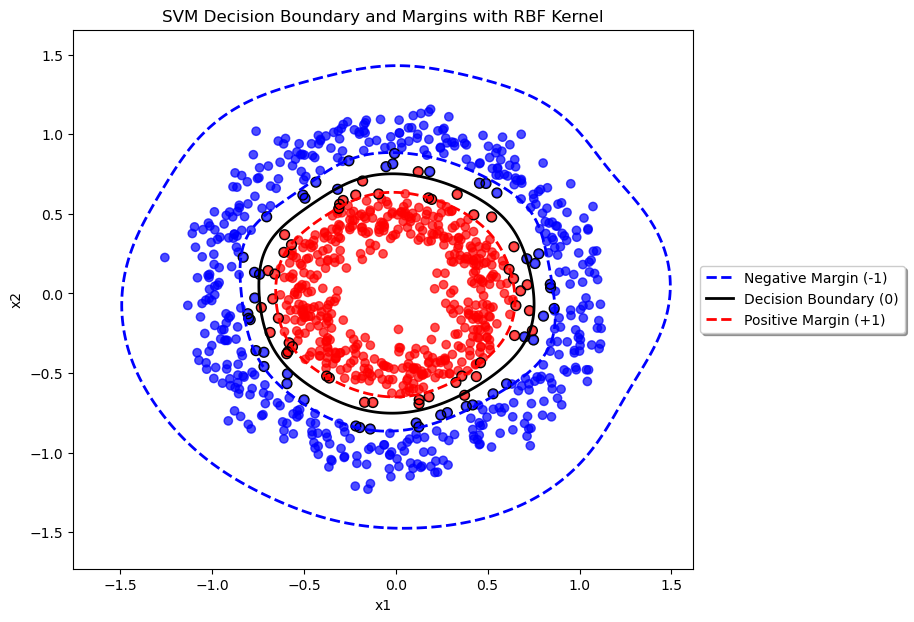

In [43]:
svm.plot_decision_boundary(x,y)

In [44]:
svm.compute_margin()

0.27650446169223125

In [45]:
svm.support_vectors()

,Feature_1,Feature_2,λ,Decision_Value
0,-0.568391,0.306051,0.9184,-0.0341
1,-0.580965,-0.310749,1.0000,0.0000
2,-0.093907,0.625336,0.8471,-0.0341
3,0.460927,-0.435679,0.2795,-0.0341
4,-0.831310,0.227585,1.0000,0.0000
...,...,...,...,...
87,-0.506171,0.618593,1.0000,0.0000
88,-0.218579,0.618532,1.0000,0.0000
89,0.700895,-0.273092,1.0000,0.0000
90,0.184414,0.765671,1.0000,0.0000


## SVM One Vs One

In [46]:
from sklearn.metrics import accuracy_score

#### Problem 1

In [47]:
from sklearn.datasets import make_blobs
x, y = make_blobs(n_samples=1000, centers=3, random_state=42, cluster_std=1.2)
model = OvoSVM(kernel='linear' , C = 0)

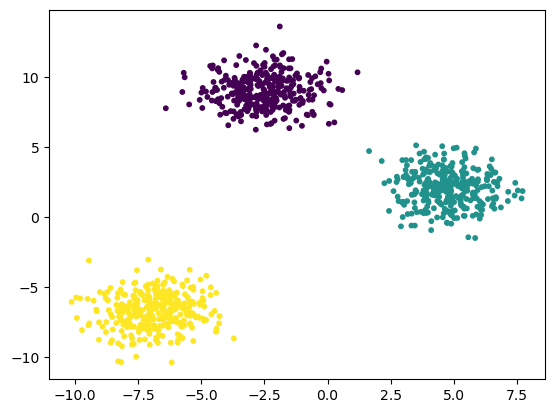

In [48]:
plt.scatter(x[:,0] , x[:,1] , c=y , s=10 , alpha=1)

In [49]:
model.fit(x,y)

In [50]:
model.compare_with_sklearn(x,y)

Comparison of Intercepts (b):

Custom OvO: [-3.44161403  0.01056317  0.44319151]
Scikit-Learn: [-3.44161268  0.0105632   0.44319152]

Comparison of Coefficients (w):

Classifier 1 (Classes (0, 1)):
Custom OvO Coefficients: [-0.45059372  0.67358151]
Scikit-Learn Coefficients: [-0.45059351  0.67358119]

Classifier 2 (Classes (0, 2)):
Custom OvO Coefficients: [0.06180299 0.18763949]
Scikit-Learn Coefficients: [0.06180299 0.18763949]

Classifier 3 (Classes (1, 2)):
Custom OvO Coefficients: [0.21442827 0.09846528]
Scikit-Learn Coefficients: [0.21442826 0.09846528]


Custom OvO Accuracy: 1.0
Sklearn OvO Accuracy: 1.0


In [51]:
model1 = SVC(kernel='linear',decision_function_shape='ovo')
model1.fit(x,y)

SVC(decision_function_shape='ovo', kernel='linear')

In [52]:
sum(model1.predict(x) == model.predict(x))

1000

In [53]:
accuracy_score(y, model.predict(x))

1.0

####  Problem 2

In [54]:
from sklearn.datasets import make_blobs
x, y = make_blobs(n_samples=1000, centers=3, random_state=42, cluster_std=2.5)
model = OvoSVM(kernel='linear' , C = 2)

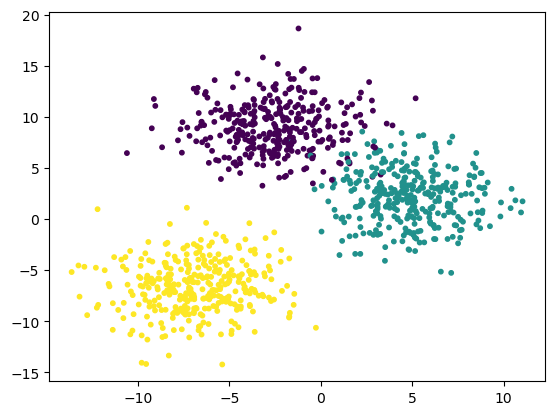

In [55]:
plt.scatter(x[:,0] , x[:,1] , c=y , s=10 , alpha=1)

In [56]:
model.fit(x,y)

In [57]:
model.compare_with_sklearn(x,y)

Comparison of Intercepts (b):

Custom OvO: [-2.57442644  0.172749    1.27315105]
Scikit-Learn: [-2.57481802  0.17288742  1.27254841]

Comparison of Coefficients (w):

Classifier 1 (Classes (0, 1)):
Custom OvO Coefficients: [-0.63726671  0.56089689]
Scikit-Learn Coefficients: [-0.63735646  0.56097412]

Classifier 2 (Classes (0, 2)):
Custom OvO Coefficients: [0.24271619 0.55008956]
Scikit-Learn Coefficients: [0.24278274 0.55024066]

Classifier 3 (Classes (1, 2)):
Custom OvO Coefficients: [0.76613578 0.24639902]
Scikit-Learn Coefficients: [0.76614429 0.24611031]


Custom OvO Accuracy: 0.983
Sklearn OvO Accuracy: 0.983


In [58]:
model1 = SVC(kernel='linear' , C = 2 , decision_function_shape='ovo')
model1.fit(x,y)

SVC(C=2, decision_function_shape='ovo', kernel='linear')

In [59]:
sum(model1.predict(x) == model.predict(x))

1000

In [60]:
accuracy_score(y, model.predict(x))

0.983

#### Problem 3

In [61]:
from sklearn.datasets import make_gaussian_quantiles
x, y = make_gaussian_quantiles(n_samples=1000, n_features=2, n_classes=3, random_state=42)

model = OvoSVM(C=2, kernel='poly', degree=4)

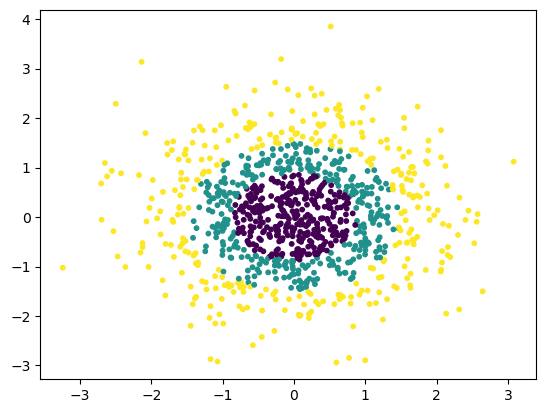

In [62]:
plt.scatter(x[:,0] , x[:,1] , c=y , s=10 , alpha=1)

In [63]:
model.fit(x,y)

In [64]:
model.compare_with_sklearn(x,y)

Comparison of Intercepts (b):

Custom OvO: [ 8.78789009  1.61695011 21.57396407]
Scikit-Learn: [ 8.7760186   1.61664781 21.59440133]

Custom OvO Accuracy: 0.994
Sklearn OvO Accuracy: 0.994


In [65]:
model1 = SVC(kernel='poly' , C = 2, degree= 4 , decision_function_shape='ovo',coef0=1, gamma=1.0)
model1.fit(x,y)

SVC(C=2, coef0=1, decision_function_shape='ovo', degree=4, gamma=1.0,
    kernel='poly')

In [66]:
sum(model1.predict(x) == model.predict(x))

1000

In [67]:
accuracy_score(y, model.predict(x))

0.994

#### Problem 4

In [68]:
from sklearn.datasets import make_gaussian_quantiles
x, y = make_gaussian_quantiles(n_samples=1000, n_features=2, n_classes=4, random_state=42)

model = OvoSVM(C=1, kernel='rbf', gamma = 4)

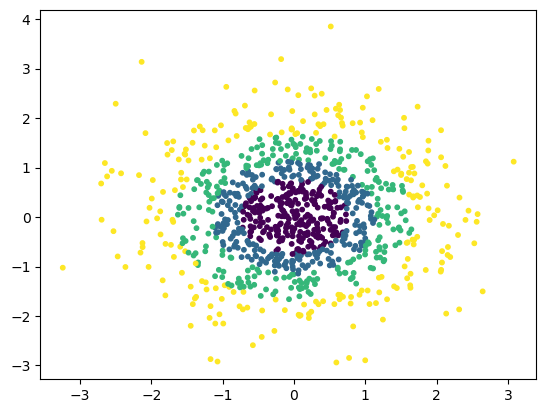

In [69]:
plt.scatter(x[:,0] , x[:,1] , c=y , s=10 , alpha=1)

In [70]:
model.fit(x,y)

In [71]:
model.compare_with_sklearn(x,y)

Comparison of Intercepts (b):

Custom OvO: [-0.84574928 -0.50410667 -0.75467982 -0.48004587 -0.67393265 -0.6969173 ]
Scikit-Learn: [-0.98234331 -0.50899645 -0.75464146 -0.45740254 -0.67564306 -0.65355364]

Custom OvO Accuracy: 0.968
Sklearn OvO Accuracy: 0.959


In [72]:
model1 = SVC(kernel='rbf', C=1, decision_function_shape='ovo', gamma=4)
model1.fit(x, y)

SVC(C=1, decision_function_shape='ovo', gamma=4)

In [73]:
sum(model1.predict(x) == model.predict(x))

987

In [74]:
accuracy_score(y, model.predict(x))

0.968

## SVM One Vs Rest

#### Problem 1

In [75]:
import numpy as np

from sklearn.datasets import make_blobs
x, y = make_blobs(n_samples=1000, centers=3, random_state=42, cluster_std= 1.3)

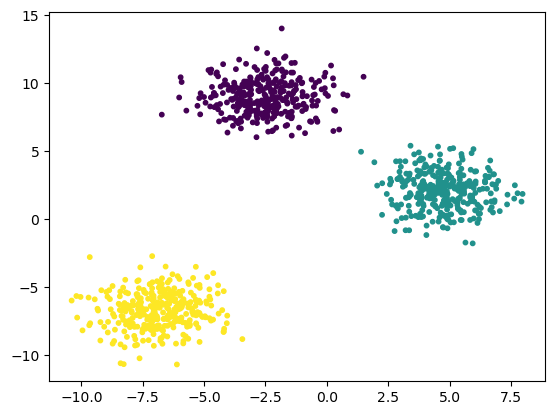

In [76]:
plt.scatter(x[:,0],x[:,1],c=y , s=10 , alpha=1)

In [77]:
model = OvrSVM(kernel='linear' , C = 0)

In [78]:
model.fit(x,y)

In [79]:
model.compare_with_sklearn(x,y)


Custom OvR Weights:
 [[-0.51369225  0.94311048]
 [ 1.52886109 -0.39087996]
 [-0.18503999 -0.20474607]]
Sklearn OvR Weights:
 [[-0.51369195  0.94310993]
 [ 1.22790057 -0.31393425]
 [-0.18506547 -0.20468524]]

Custom OvR Biases:
 [-4.9553457   0.80928829 -0.67101669]
Sklearn OvR Biases:
 [-4.95534266  0.4531261  -0.67114679]

Custom OvR Accuracy: 1.0
Sklearn OvR Accuracy: 1.0


In [80]:
sklearn_model = OneVsRestClassifier(SVC(kernel='linear'))
sklearn_model.fit(x,y)

OneVsRestClassifier(estimator=SVC(kernel='linear'))

In [81]:
sum(sklearn_model.predict(x) == model.predict(x))

1000

#### Problem 2

In [82]:
import numpy as np

from sklearn.datasets import make_blobs
x, y = make_blobs(n_samples=1000, centers=3, random_state=42, cluster_std= 3)

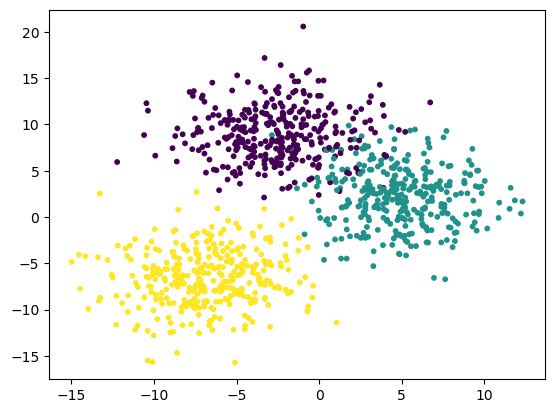

In [83]:
plt.scatter(x[:,0],x[:,1],c=y , s=10 , alpha=1)

In [84]:
model = OvrSVM(kernel='linear' , C = 1)

In [85]:
model.fit(x,y)

In [86]:
model.compare_with_sklearn(x,y)


Custom OvR Weights:
 [[-0.34707656  0.60109032]
 [ 0.61944636 -0.11875528]
 [-0.72377094 -0.77652544]]
Sklearn OvR Weights:
 [[-0.34684773  0.60080054]
 [ 0.61957275 -0.11884968]
 [-0.72425686 -0.77726171]]

Custom OvR Biases:
 [-3.28926864 -0.33870482 -2.7382845 ]
Sklearn OvR Biases:
 [-3.2875395  -0.33865931 -2.74091756]

Custom OvR Accuracy: 0.968
Sklearn OvR Accuracy: 0.968


In [87]:
sklearn_model = OneVsRestClassifier(SVC(kernel='linear' , C = 1))
sklearn_model.fit(x,y)

OneVsRestClassifier(estimator=SVC(C=1, kernel='linear'))

In [88]:
sum(sklearn_model.predict(x) == model.predict(x))

1000

#### Problem 3

In [89]:
from sklearn.datasets import make_gaussian_quantiles
x, y = make_gaussian_quantiles(n_samples=1000, n_features=2, n_classes=4, random_state=42)

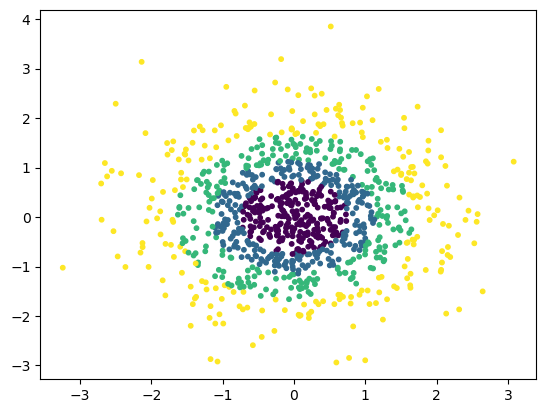

In [90]:
plt.scatter(x[:,0],x[:,1],c=y , s=10 , alpha=1)

In [91]:
model = OvrSVM(kernel='poly' , C = 1 , degree = 3)

In [92]:
model.fit(x,y)
model.compare_with_sklearn(x,y)


Custom OvR Biases:
 [  4.8690641   -0.5         -0.5        -15.58322736]
Sklearn OvR Biases:
 [  4.84096644  -0.99983145  -0.99992285 -15.61710705]

Custom OvR Accuracy: 0.849
Sklearn OvR Accuracy: 0.737


In [93]:
sklearn_model = OneVsRestClassifier(SVC(kernel='poly' , C = 1 , degree = 3 , coef0=1, gamma=1.0))
sklearn_model.fit(x,y)

OneVsRestClassifier(estimator=SVC(C=1, coef0=1, gamma=1.0, kernel='poly'))

In [94]:
sum(sklearn_model.predict(x) == model.predict(x))

826

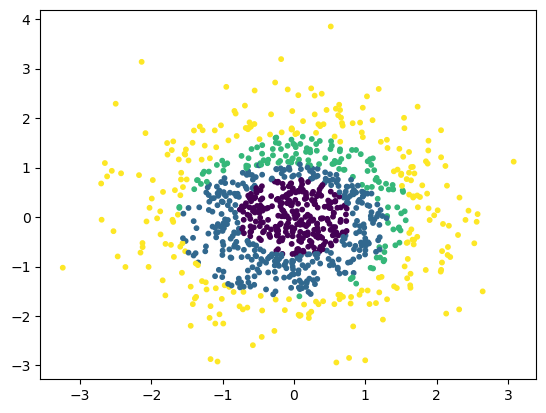

In [95]:
plt.scatter(x[:,0], x[:,1] , c= model.predict(x), s=10 , alpha=1)

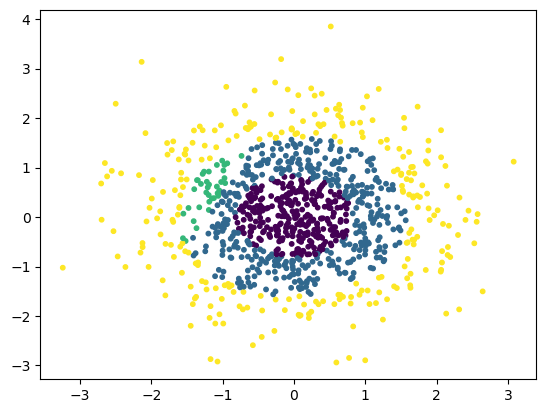

In [96]:
plt.scatter(x[:,0], x[:,1] , c= sklearn_model.predict(x) , s=10 , alpha=1)

#### Problem 4

In [97]:
model = OvrSVM(kernel='rbf' , C = 1 , gamma = 3)

In [98]:
model.fit(x,y)
model.compare_with_sklearn(x,y)


Custom OvR Biases:
 [-1.07281537 -1.89261416 -1.24684193  0.56627307]
Sklearn OvR Biases:
 [-1.20304594 -1.6823991  -1.15989305  0.54371732]

Custom OvR Accuracy: 0.963
Sklearn OvR Accuracy: 0.957


In [99]:
sklearn_model = OneVsRestClassifier(SVC(kernel='rbf' , C = 1 , gamma=3.0))
sklearn_model.fit(x,y)

OneVsRestClassifier(estimator=SVC(C=1, gamma=3.0))

In [100]:
sum(sklearn_model.predict(x) == model.predict(x))

986

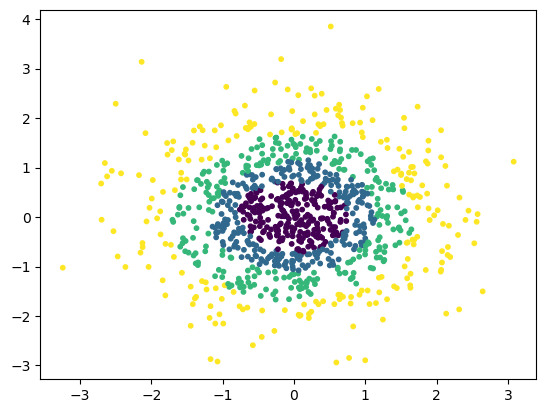

In [101]:
plt.scatter(x[:,0], x[:,1] , c= model.predict(x) , s=10 , alpha=1)